# 03 Genotype classifier

In this notebook we'll explore LIME and Anchors and figure out if we can learn something from black-box ML models.


**Objectives:**
* use Boruta to find the involved features
* train a GBM classifier that predicts genotype
    * CV
    * optimization? 
* explain using LIME
* explain using Anchors

**Refs:**
* https://kkulma.github.io/2017-11-07-automated_machine_learning_in_cancer_detection/

In [14]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

sns.set(style="whitegrid")

---

## Load the data

In [15]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [16]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 112 ms, sys: 257 ms, total: 370 ms
Wall time: 146 ms


In [17]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 16.4 s, sys: 7.49 s, total: 23.9 s
Wall time: 23.9 s


In [18]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [19]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT'] = st_df['GT'].astype('category', copy=False)
st_df['age'] = st_df['age_GT'].astype('category', copy=False)
st_df['age_GT'] = st_df['age_GT'].astype('category', copy=False)

In [20]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

In [21]:
expression_df = st_df[gene_columns]

In [22]:
assert expression_df.shape == (10327, 46454)

In [26]:
genotype_df = st_df[['GT']]

---

## Extract *all-relevant* feature set

* use Boruta to reduce the transcriptome feature space to only the genes that perform significantly better than their scrambled counterparts.

**Observations:**
* remarkably, boruta spits out way more relevant features than when regressing on `[AB1_StdDev_Yen]`.

In [32]:
boruta_rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features='sqrt', max_depth=5)

def train_feature_selector(X_df=expression_df,  # the transcriptome expression vectors
                           y_df=genotype_df,    # the Genotype meta data column
                           estimator=boruta_rf, verbose=2, seed=42):  # boruta parameters
    feature_selector = BorutaPy(estimator=estimator, verbose=verbose, random_state=seed, n_estimators='auto')    
    
    X = X_df.as_matrix()
    y = y_df.values.ravel()
    feature_selector.fit(X, y)
    
    return feature_selector

In [ ]:
GT_feature_selector = train_feature_selector()

In [42]:
GT_features = list(gene_columns[GT_feature_selector.support_])

In [280]:
GT_features_BAK = GT_features

In [284]:
pd.DataFrame(GT_features_BAK).to_csv('03_GT_features.txt', index=None, header=None)

In [281]:
def keep(gene):
    rik = gene.endswith('Rik')
    Gm_ = re.search('^Gm[0-9]+', gene) is not None
    
    return not (rik or Gm_)

GT_features = list(filter(lambda gene: keep(gene), GT_features))

In [285]:
len(GT_features)

1226

---

# Train a GBM classifier

* grid search
* random search
* CV evaluation of a model

**Observations:**
* we can train an almost perfect classifier with GBM
* 5000 trees with default SGBM params and early stopping monitor
* probably overfits, try with less trees

In [57]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit

In [83]:
EARLY_STOP_WINDOW_LENGTH = 25

DEFAULT_SGBM_KWARGS = {
    'learning_rate': 0.01,
    'n_estimators': 10000,  # can be arbitrarily large
    'max_features': 0.1,
    'subsample': 0.9
}

class EarlyStopMonitor:

    def __init__(self, window_length=EARLY_STOP_WINDOW_LENGTH, threshold=0):        
        self.window_length = window_length
        self.threshold = threshold

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, estimator, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(estimator.oob_improvement_[lo: hi]) < self.threshold
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

In [294]:
X = st_df[GT_features]
y = st_df['GT']

In [62]:
%%time
n_folds = 10
test_size = 0.2
cv = ShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=42)

sgbm = GradientBoostingClassifier(random_state=42, **DEFAULT_SGBM_KWARGS)
scores = cross_val_score(sgbm, X, y, cv=cv, n_jobs=-1, fit_params={'monitor': EarlyStopMonitor()}, groups=st_df[['GT', 'age']])

scores

stopped after rounds: 5673
stopped after rounds: 5640
stopped after rounds: 5807
stopped after rounds: 5825
stopped after rounds: 5875
stopped after rounds: 5941
stopped after rounds: 5827
stopped after rounds: 5946
stopped after rounds: 5958
stopped after rounds: 5976


array([0.99854792, 0.99903195, 0.99854792, 0.99951597, 0.99903195,
       1.        , 0.99951597, 0.99854792, 0.99951597, 0.99903195])

* check out performance with 1000 trees
* guess: still quite good inference

In [71]:
%%time
n_folds = 10
test_size = 0.2
cv = ShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=42)

SGBM_KWARGS = {
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'max_features': 0.1,
    'subsample': 0.9
}

sgbm = GradientBoostingClassifier(random_state=42, **SGBM_KWARGS)
scores = cross_val_score(sgbm, X, y, cv=cv, n_jobs=-1, 
                         # fit_params={'monitor': EarlyStopMonitor()},  no need for early stopping
                         groups=st_df[['GT', 'age']])

CPU times: user 3.57 s, sys: 26.4 s, total: 29.9 s
Wall time: 2min 27s


In [72]:
scores

array([0.99709584, 0.99612778, 0.99709584, 0.99854792, 0.99709584,
       0.99903195, 0.99806389, 0.99515973, 0.99709584, 0.99806389])

In [89]:
%%time
n_folds = 10
test_size = 0.2
cv = ShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=42)

SGBM_KWARGS = {
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'max_features': 0.1,
    'subsample': 0.9
}

sgbm = GradientBoostingClassifier(random_state=42, **SGBM_KWARGS)
scores = cross_val_score(sgbm, X, y, cv=cv, n_jobs=-1, 
                         fit_params={'monitor': EarlyStopMonitor(threshold=0.001)},
                         groups=st_df[['GT', 'age']])

stopped after rounds: 340
stopped after rounds: 338
stopped after rounds: 340
stopped after rounds: 348
stopped after rounds: 347
stopped after rounds: 340
stopped after rounds: 348
stopped after rounds: 340
stopped after rounds: 348
stopped after rounds: 348
CPU times: user 3.35 s, sys: 27.3 s, total: 30.7 s
Wall time: 1min 14s


In [90]:
scores

array([0.99031946, 0.98983543, 0.98547919, 0.99225557, 0.99225557,
       0.99128751, 0.98983543, 0.98789932, 0.9893514 , 0.9893514 ])

---

# GBM variable importance for **GT** classification

In [301]:
train_idx, test_idx = list(ShuffleSplit(n_splits=2, test_size=0.2, random_state=666).split(X, y))[0]

In [302]:
X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

In [303]:
sgbm = GradientBoostingClassifier(random_state=42, learning_rate=0.01, n_estimators=250, max_features=0.1)

In [304]:
sgbm.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=250, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [305]:
len(list(sgbm.feature_importances_))

1226

In [306]:
genes_by_importances = pd.DataFrame({'gene': GT_features, 'importance': sgbm.feature_importances_})

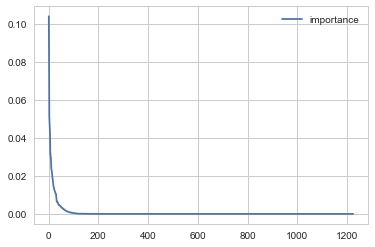

In [307]:
genes_by_importances.sort_values(by='importance', ascending=False).plot(use_index=False)
plt.show()

In [308]:
genes_by_importances.sort_values(by='importance', ascending=False).head(50)

,gene,importance
969,Sez6,0.103884
233,Cst7,0.082352
1068,Tbx1,0.051042
514,Lrrc17,0.048030
814,Rpl12,0.045526
239,Ctsd,0.042009
147,Ccl21c.1,0.031494
1205,mt-Rnr2,0.031416
659,Olfr912.1,0.029300
1140,Tyrobp,0.028021


In [ ]:
len(y_test)

In [ ]:
predicted_probs[:, 0]

In [309]:
predicted_labels = sgbm.predict(X_test)
predicted_probs = sgbm.predict_proba(X_test)

predicted_df = pd.DataFrame({'predicted': predicted_labels, 
                             'actual': y_test,
                             'KI_prob': predicted_probs[:, 0],
                             'WT_prob': predicted_probs[:, 1]})

In [310]:
predicted_correct = predicted_df[predicted_df['actual'] == predicted_df['predicted']]
predicted_wrong = predicted_df[predicted_df['actual'] != predicted_df['predicted']]

In [418]:
predicted_wrong.loc[110]

KI_prob      0.489945
WT_prob      0.510055
actual             KI
predicted          WT
Name: 110, dtype: object

In [422]:
y_train.loc[227]

'KI'

* KI is more often misclassifies as WT, which is expected

In [425]:
sgbm.predict_proba(X_train.loc[[227]])

array([[0.72364738, 0.27635262]])

In [426]:
X_train.loc[227]

AA474408       2.982974
AC149090.1     8.032176
AU020206       2.982974
Aatk           5.874788
Abca2          2.982974
Abhd4          7.323970
Aco2           8.032176
Acot13         2.982974
Acsbg1         7.323970
Actb           9.999121
Actg1          8.693815
Actr1a         8.287930
Acyp2          2.982974
Adcyap1r1      2.982974
Adgrl1         7.721100
Adprh          2.982974
Aes            6.774170
Agap2          7.323970
Akap7          5.874788
Akr7a5         2.982974
Aldh1a1        2.982974
Aldh9a1        2.982974
Aldoa         10.531711
Aldoc          9.848356
Anln           2.982974
Anxa3          2.982974
Anxa5          2.982974
Ap2m1          7.721100
Apbb1          7.323970
Apex1          7.323970
                ...    
mt-Cytb       14.194090
mt-Nd1        13.325327
mt-Nd2        12.857366
mt-Nd3        12.354684
mt-Nd4        14.067548
mt-Nd4l        9.010224
mt-Nd5        11.398157
mt-Nd6         8.693815
mt-Rnr1       14.411361
mt-Rnr2       14.965569
mt-Ta          8

---

# LIME explanations

* See: https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html

In [335]:
import lime 
import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

In [336]:
iris = sklearn.datasets.load_iris()

In [437]:
%time
explainer = LimeTabularExplainer(X_train, 
                                 feature_names=GT_features, 
                                 class_names=sgbm.classes_, 
                                 discretize_continuous=False, 
                                 random_state=42)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 21 µs


In [432]:
exp_68 = explainer.explain_instance(X_test.loc[68], sgbm.predict_proba, num_features=20)
exp_110 = explainer.explain_instance(X_test.loc[110], sgbm.predict_proba, num_features=20)

In [433]:
exp_227 = explainer.explain_instance(X_train.loc[227], sgbm.predict_proba, num_features=20)

In [438]:
with open("exp_68.html", "w") as html_file:
    html_file.write(exp_68.as_html(show_predicted_value=True))

In [439]:
with open("exp_110.html", "w") as html_file:
    html_file.write(exp_110.as_html())

In [440]:
with open("exp_227.html", "w") as html_file:
    html_file.write(exp_227.as_html())

---

# Anchor explanations